### Description:
    This script implements Active Learning using the Query by Committee (QBC) strategy.
    A committee of models is trained on different bootstrap samples of the labeled data.
    For the unlabeled pool, we measure the committee's disagreement via vote entropy and select
    the most uncertain samples for labeling. The model's performance on the validation set is
    evaluated (using majority vote over the committee), and results are plotted over iterations.

In [9]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import math

In [10]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
model_name = "distilbert-base-uncased"
num_labels = 2  

def create_model():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    return model

tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_dataset = load_dataset("glue", "sst2", split="train")
val_dataset = load_dataset("glue", "sst2", split="validation")

In [5]:
def collate_fn(batch):
    texts = [item["sentence"] for item in batch]
    labels = [item["label"] for item in batch]
    tokenized_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    tokenized_inputs["labels"] = torch.tensor(labels)
    return tokenized_inputs


### Active Learning:

In [6]:
initial_label_size = 50
acquisition_size = 50
max_iterations = 10
committee_size = 3  # Number of models in the committee

In [7]:
all_indices = list(range(len(train_dataset)))
random.shuffle(all_indices)

labeled_indices = all_indices[:initial_label_size]
unlabeled_indices = all_indices[initial_label_size:]

In [8]:
labeled_sizes = []
val_accuracies = []

#### Active Learning Loop:

In [11]:
for iteration in range(max_iterations):
    print(f"\n=== Active Learning Iteration {iteration+1} ===")
    
    # --- Committee Training ---
    committee = []
    for i in range(committee_size):
    
        model = create_model().to(device)
        optimizer = AdamW(model.parameters(), lr=2e-5)
        
        bootstrap_indices = np.random.choice(labeled_indices, size=len(labeled_indices), replace=True)
        bootstrap_subset = Subset(train_dataset, bootstrap_indices)
        bootstrap_loader = DataLoader(bootstrap_subset, batch_size=16, shuffle=True, collate_fn=collate_fn)
        
        model.train()
        epochs = 2
        for epoch in range(epochs):
            epoch_loss = 0
            for batch in tqdm(bootstrap_loader, desc=f"Training Committee Member {i+1}, Epoch {epoch+1}"):
                optimizer.zero_grad()
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            print(f"Committee Member {i+1}, Epoch {epoch+1} Loss: {epoch_loss/len(bootstrap_loader):.4f}")
        
        committee.append(model)

    # --- Evaluation on the Validation Set using Committee Majority Vote ---
    val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
    all_votes = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating Committee on Validation Set"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            batch_votes = []  
            
            for model in committee:
                model.eval()
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
                batch_votes.append(preds.cpu().numpy())
            
            batch_votes = np.array(batch_votes).T  # shape: (batch_size, committee_size)
            
            for votes in batch_votes:
                vote_counts = Counter(votes)
                majority_vote = vote_counts.most_common(1)[0][0]
                all_votes.append(majority_vote)
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = np.mean(np.array(all_votes) == np.array(all_labels))
    print(f"Validation Accuracy (Committee Majority Vote): {accuracy*100:.2f}%")
    labeled_sizes.append(len(labeled_indices))
    val_accuracies.append(accuracy)

    # --- Acquisition: Query by Committee using Vote Entropy ---
    if len(unlabeled_indices) == 0:
        break

    unlabeled_subset = Subset(train_dataset, unlabeled_indices)
    unlabeled_loader = DataLoader(unlabeled_subset, batch_size=32, collate_fn=collate_fn)
    
    vote_entropy_list = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(unlabeled_loader, desc="Computing Vote Entropy for Unlabeled Samples")):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            committee_preds = []
            for model in committee:
                model.eval()
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
                committee_preds.append(preds.cpu().numpy())
            
            committee_preds = np.array(committee_preds)  # shape: (committee_size, batch_size)
            
            batch_size = committee_preds.shape[1]
            for j in range(batch_size):
                votes = committee_preds[:, j]  
                vote_counts = Counter(votes)
                
                entropy = 0.0
                for cls in range(num_labels):
                    p = vote_counts.get(cls, 0) / committee_size
                    if p > 0:
                        entropy -= p * math.log(p)
                
                global_index = unlabeled_indices[batch_idx * 32 + j]
                vote_entropy_list.append((global_index, entropy))
    
    vote_entropy_list.sort(key=lambda x: x[1], reverse=True)
    
    selected_samples = [idx for idx, ent in vote_entropy_list[:acquisition_size]]
    
    labeled_indices.extend(selected_samples)
    unlabeled_indices = list(set(unlabeled_indices) - set(selected_samples))
    
    print(f"Total labeled samples after acquisition: {len(labeled_indices)}")



=== Active Learning Iteration 1 ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Committee Member 1, Epoch 1: 100%|██████████| 4/4 [00:12<00:00,  3.21s/it]


Committee Member 1, Epoch 1 Loss: 0.6849


Training Committee Member 1, Epoch 2: 100%|██████████| 4/4 [00:13<00:00,  3.45s/it]


Committee Member 1, Epoch 2 Loss: 0.6147


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Committee Member 2, Epoch 1: 100%|██████████| 4/4 [00:14<00:00,  3.54s/it]


Committee Member 2, Epoch 1 Loss: 0.6678


Training Committee Member 2, Epoch 2: 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


Committee Member 2, Epoch 2 Loss: 0.6286


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Committee Member 3, Epoch 1: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


Committee Member 3, Epoch 1 Loss: 0.7001


Training Committee Member 3, Epoch 2: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Committee Member 3, Epoch 2 Loss: 0.6573


Evaluating Committee on Validation Set: 100%|██████████| 28/28 [01:35<00:00,  3.42s/it]


Validation Accuracy (Committee Majority Vote): 50.92%


Computing Vote Entropy for Unlabeled Samples:  47%|████▋     | 980/2104 [3:28:41<3:59:21, 12.78s/it]    


KeyboardInterrupt: 

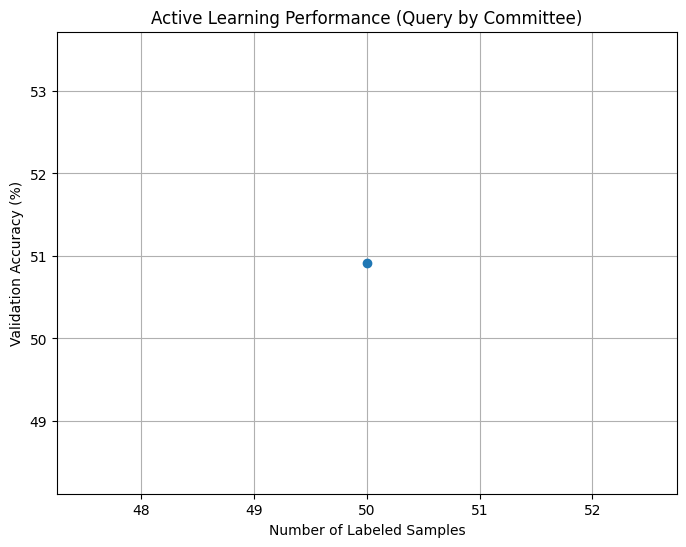

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(labeled_sizes, [acc * 100 for acc in val_accuracies], marker='o', linestyle='-')
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Validation Accuracy (%)")
plt.title("Active Learning Performance (Query by Committee)")
plt.grid(True)
plt.show()